# Support Vector Machines
SVMs are particularly well suited for classification of complex but small- or medium-sized datasets.

## Linear SVM Classification
Fitting the widest possible street between the classes that are being classified. Also called, large margin classification.

The *support vectors* are the data points that are closes to the classifying borders and that *support* the street. There are two types:

- Hard margin classification: Impose that all instances be off hte street and on the right side. Requires linearly separable data and is sensitive to outliers.

- Soft margin classification: Find a balance between keeping *street wide* and limiting the margin violations.

This is controlled by the `C` hyperparameter in Scikit-Learn. Higher values means less margin violations.

Will use the iris data set to test it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
## Load the iris data set
iris = datasets.load_iris()

## Will only use petal length and width as features
X = iris["data"][:, (2,3)]

## The aim is to detect Iris-Virginica flowers (target == 2)
y = (iris["target"] == 2).astype(np.float64)

## Build the pipeline (scaling + linear regression)
svm_clf = Pipeline((("Scaler", StandardScaler()), ("linear_svc", LinearSVC(C=1, loss="hinge"))))

## Fit the model
svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [3]:
## Get coeficients
svm_clf.named_steps['linear_svc'].coef_

## Use it to make prediction
svm_clf.predict([[5.5, 1.7]])

array([ 1.])

Unlike logistic regression, SVM classifiers do not ouput probabilities for each class. However, there are ways to turn the ouptut into a logit-type function (Platt scaling).

Important: The `LinearSVC` class regularizes the bias term so the data **must** be centred by subtracting its mean. This is done automatically by the `StandardScaler` method used above.

## Nonlinear SVM Classification
Many datasets are not even close to being linearly separable. One option is to add polynomial features before fitting the model.

In this example the dataset has two features which we will call x_1 and x_2

In [4]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline([("poly_features",PolynomialFeatures(degree=3)),
                               ("scaler",StandardScaler()),
                              ("svm_clf", LinearSVC(C=10, loss="hinge"))])

polynomial_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

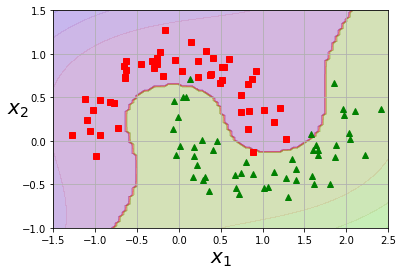

In [5]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "rs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.show()

Works quite well!

### Polynomial Kernel
Complex datasets may require high order polynomial which create a large number of features and make the model slow. Fortunately, the *kernel trick* implemented in the `SVC` class allows the same result without having to add the terms. See below

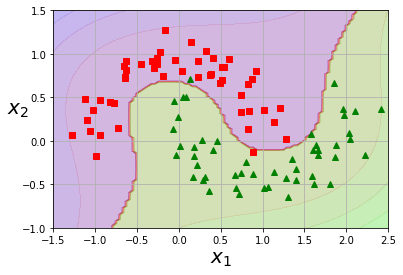

In [6]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([("scaler", StandardScaler()), ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5, probability=True))])
poly_kernel_svm_clf.fit(X,y)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.show()

In [7]:
## This uses Platt scaling to give a probability instead of just the class!
# poly_kernel_svm_clf.predict_proba(X)

## SVM Regression

In addition to classification, the SVM algorithm also supports regression. The trick is to reverse the objective: instead of fitting the largest possible street while limiting margin violations, SVM regression tries to fit as many instance as possible on the street while limiting margin violations. The width of the street is controlled by the tolerance parameter epsilon.

Let's test it with some random data

In [8]:
m = 50
X= 2 * np.random.rand(m,1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [9]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

In [10]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X,y,"bo")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$y$", fontsize=20, rotation=0)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, 'k-')
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")

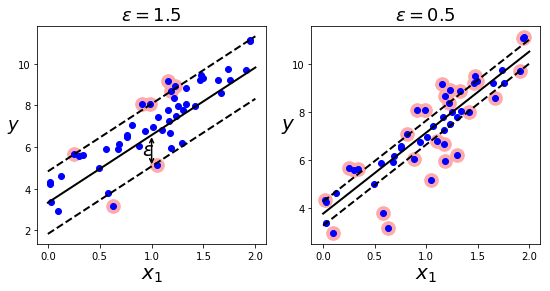

In [11]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()